<a href="https://colab.research.google.com/github/mburkasov/Financial-forecasting/blob/main/Case_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import requests

from google.colab import drive
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

In [ ]:
excel = requests.get('https://drive.google.com/u/0/uc?id=1mFvotKrTGKV1j0mBoN_s3RIzm3mtmcoS&export=download')
df1 = pd.read_excel(excel.content)

In [ ]:
def putfirst(list, item):
  if item in list:
    list.remove(item)
    list = [item] + list
  return list

def export_prediction(pred, filename = 'output'):
  drive.mount('/content/drive')
  pred=pd.DataFrame(pred)
  pred.to_excel(f'/content/drive/My Drive/Colab Notebooks/{filename}.xlsx')

In [ ]:
df = df1.copy()
 
#remove id column
df.pop('SK_ID_CURR')
 
#replace some NAs
df['HOUSETYPE_MODE'] = df['HOUSETYPE_MODE'].fillna('No')
df['EMERGENCYSTATE_MODE'] = df['EMERGENCYSTATE_MODE'].fillna('No')
 
#make some strings into integer
chlist = []
for column in df.select_dtypes(include='object'):
  naming = df[column].value_counts().index.tolist()
  naming = putfirst(naming, 'N')
  if len(naming) <= 4:
    for n, title in enumerate(naming):
      df[column] = df[column].replace(title, n)
    chlist.append(column)
print('Transformed columns: ',chlist)
 
#remove columns with all the same values
print('Removed: ', end='')
for column in df.select_dtypes(exclude='object'):
  if df[column].max()-df[column].min() == 0:
    df.pop(column)
    print(column, end=', ')
 
#make other strings into columns
df = pd.get_dummies(df)
 
columns = df.columns.to_list()

Transformed columns:  ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE']
Removed: FLAG_MOBIL, FLAG_DOCUMENT_2, FLAG_DOCUMENT_7, FLAG_DOCUMENT_10, FLAG_DOCUMENT_12, 

In [ ]:
for column in df:
  nacount = df[column].isna().sum()
  if nacount > 0:
    print(column, nacount)

In [ ]:
df.corr().abs().sort_values('TARGET', ascending=False).round(2).head(15)

In [ ]:
 
#заменить на моду для категорий
imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler()
 
imputer.fit(df)
df = imputer.transform(df)

scaler.fit(df)
df = scaler.transform(df)

In [ ]:
columns.remove('TARGET')

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

Y = df[:,0]
X = df[:,1:]

k = 15

bestfeatures = SelectKBest(score_func=f_classif, k=k)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(k,'Score'))

list1 = featureScores.nlargest(15,'Score').iloc[:,0].tolist()

bestfeatures = SelectKBest(score_func=chi2, k=k)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(k,'Score'))

list2 = featureScores.nlargest(5,'Score').iloc[:,0].tolist()

                                                 Specs       Score
32                                        EXT_SOURCE_3  199.457764
31                                        EXT_SOURCE_2  152.930900
30                                        EXT_SOURCE_1   51.019117
119               NAME_EDUCATION_TYPE_Higher education   35.698871
22                         REGION_RATING_CLIENT_W_CITY   34.958701
21                                REGION_RATING_CLIENT   34.261682
10                                          DAYS_BIRTH   32.222351
117                           NAME_INCOME_TYPE_Working   26.695472
122  NAME_EDUCATION_TYPE_Secondary / secondary special   26.025817
13                                     DAYS_ID_PUBLISH   25.486116
83                              DAYS_LAST_PHONE_CHANGE   22.485063
80                            DEF_30_CNT_SOCIAL_CIRCLE   20.633790
12                                   DAYS_REGISTRATION   18.631203
1                                          CODE_GENDER   17.01

In [ ]:
different = set(list2) - set(list1)
different = __builtins__.list(different)
finallist = list1 + different

In [ ]:
df = pd.DataFrame(df, columns=['TARGET'] + columns)
features = ['TARGET'] + finallist

train = df[features].iloc[:-2000]
test = df[features].iloc[-2000:-1000]
pred = df[features].iloc[-1000:,1:]

alltrain = df[features].iloc[:-1000]

In [ ]:
y = train.iloc[:,0]
x = train.iloc[:,1:]
y1 = test.iloc[:,0]
x1 = test.iloc[:,1:]
y2 = alltrain.iloc[:,0]
x2 = alltrain.iloc[:,1:]
x=sm.add_constant(x)
x1=sm.add_constant(x1)
x2=sm.add_constant(x2)
pred=sm.add_constant(pred)

In [ ]:
logit_model = sm.Logit(y,x).fit()
prediction=logit_model.predict(x1)

logit_roc_auc=roc_auc_score(y1, prediction)
fpr,tpr,thresholds=roc_curve(y1, prediction)

Optimization terminated successfully.
         Current function value: 0.234379
         Iterations 8


In [ ]:
import sklearn
from sklearn import ensemble
rf = sklearn.ensemble.RandomForestClassifier().fit(x,y)
prediction1=rf.predict_proba(x1)[:,1]

logit_roc_auc1=roc_auc_score(y1,prediction1)
fpr1,tpr1,thresholds1=roc_curve(y1,prediction1)

In [ ]:
gb=sklearn.ensemble.GradientBoostingClassifier().fit(x,y)
prediction2 = gb.predict_proba(x1)[:,1]

logit_roc_auc2 = roc_auc_score(y1,prediction2)
fpr2,tpr2,thresholds2=roc_curve(y1,prediction2)

In [ ]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(activation='logistic')

nn=nn.fit(x,y)
prediction3=nn.predict_proba(x1)[:,1]

logit_roc_auc3=roc_auc_score(y1,prediction3)
fpr3,tpr3,thresholds3=roc_curve(y1,prediction3)

nn=nn.fit(x2,y2)
predictionexport=nn.predict_proba(pred)[:,1]
export_prediction(predictionexport)

Mounted at /content/drive


In [ ]:
from lightgbm import LGBMClassifier

clf2 = LGBMClassifier()
clf2.fit(x, y)

prediction4 = clf2.predict_proba(x1)[:, 1]

logit_roc_auc4=roc_auc_score(y1,prediction4)
fpr4,tpr4,thresholds4=roc_curve(y1,prediction4)

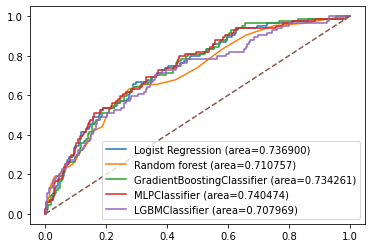

In [ ]:
plt.plot(fpr,tpr,label = 'Logist Regression (area=%0.6f)' % logit_roc_auc)
plt.plot(fpr1,tpr1,label = 'Random forest (area=%0.6f)' % logit_roc_auc1)
plt.plot(fpr2,tpr2,label = 'GradientBoostingClassifier (area=%0.6f)' % logit_roc_auc2)
plt.plot(fpr3,tpr3,label = 'MLPClassifier (area=%0.6f)' % logit_roc_auc3)
plt.plot(fpr4,tpr4,label = 'LGBMClassifier (area=%0.6f)' % logit_roc_auc4)

t=np.linspace(0,1,10)
plt.plot(t,t,linestyle='dashed')
plt.legend()